In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

In [2]:
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

In [3]:
from keras.datasets import cifar10

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))

170508288/170498071 [==============================] - 2s 0us/step
((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


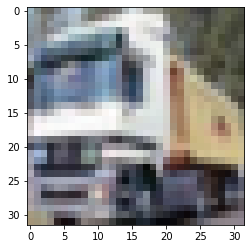

In [6]:
img = plt.imshow(x_train[1])

In [7]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=y_train.shape[1])

83697664/83683744 [==============================] - 0s 0us/step


In [8]:
data_augmentation = Sequential(
    [RandomFlip("horizontal"), 
     RandomRotation(0.1),
     RandomZoom(0.1)]
)

In [9]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = data_augmentation(x)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation=('softmax'))(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        208614

In [11]:
def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
    
    return

In [12]:
base_model.trainable = True

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
epochs = 12
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, verbose=1)

Epoch 1/12
1563/1563 [==============================] - 1059s 665ms/step - loss: 0.5141 - accuracy: 0.8260 - val_loss: 0.1958 - val_accuracy: 0.9369
Epoch 2/12
1563/1563 [==============================] - 1027s 657ms/step - loss: 0.2337 - accuracy: 0.9215 - val_loss: 0.1510 - val_accuracy: 0.9489
Epoch 3/12
1563/1563 [==============================] - 1027s 657ms/step - loss: 0.1829 - accuracy: 0.9384 - val_loss: 0.1318 - val_accuracy: 0.9567
Epoch 4/12
1563/1563 [==============================] - 1028s 658ms/step - loss: 0.1522 - accuracy: 0.9488 - val_loss: 0.1233 - val_accuracy: 0.9613
Epoch 5/12
1563/1563 [==============================] - 1029s 658ms/step - loss: 0.1323 - accuracy: 0.9549 - val_loss: 0.1203 - val_accuracy: 0.9617
Epoch 6/12
1563/1563 [==============================] - 1028s 658ms/step - loss: 0.1098 - accuracy: 0.9619 - val_loss: 0.1108 - val_accuracy: 0.9641
Epoch 7/12
1563/1563 [==============================] - 1030s 659ms/step - loss: 0.0964 - accuracy: 0.9672

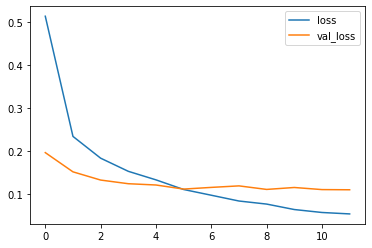

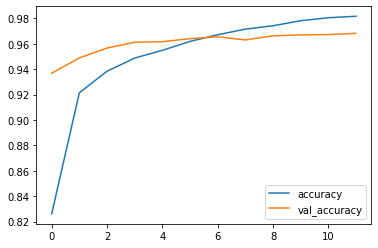

In [15]:
plot_history(history)

[[Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 [Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')]]

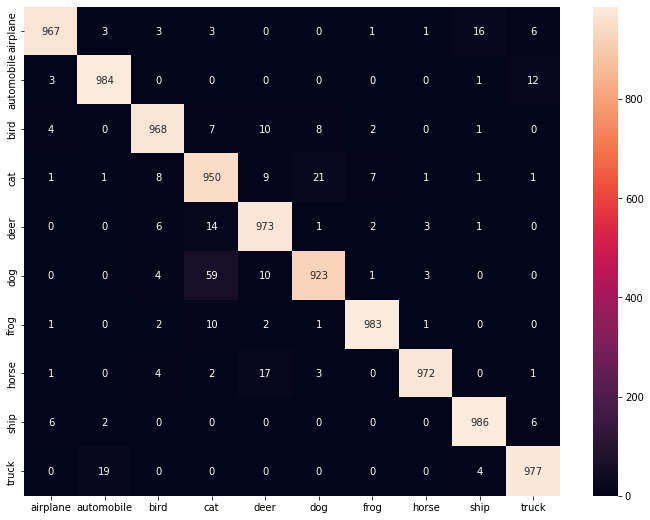

In [16]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predictions=model.predict(x_val)

y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)

In [17]:
score = model.evaluate(x_val, y_val, verbose=0) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.10917574167251587 / Test accuracy: 0.9682999849319458


In [18]:
score = model.evaluate(x_train, y_train, verbose=0) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.016088498756289482 / Test accuracy: 0.995140016078949
